# Fit attraverso integrazione della posterior

In [168]:
#FIT LINEARE CON MINIMI QUADRATI
import matplotlib.pyplot as plt

from matplotlib import cm

import numpy
from numpy import sqrt,floor

import numpy as np
import pandas as pd
import random
import math

# libreria locale
import my_lib_santanastasio as my
##NOTA IMPORTANTE: se cambi qualcosa in my_lib_santanastasio 
# devi fare Kernel --> Restart prima di rigirare il codice
# altrimenti i cambiamenti non saranno applicati.

from scipy import stats
import scipy.integrate as integrate
from scipy import optimize

def posterior(M, C, T, t, sigmaT, Tf):
    Yexp = Tf - (Tf - C)*np.exp(-t/M)
    return np.prod(stats.norm.pdf(T, Yexp, sigmaT))

c_ranges_acqua = [(35.01, 35.06), (24.99, 25.03), (21.075, 21.125), (19.4, 19.435), (18.525, 18.575), (17.99, 18.03), (17.54, 17.6)]
m_ranges_acqua = [(3.675, 3.695), (4.55, 4.61), (5.80, 5.97), (7.0, 7.45), (7.85, 8.45), (6, 6.5), (6.0, 6.85)]

m_ranges_aria = []
c_ranges_aria = []

time, Temp= np.loadtxt("data/fit_aria/temp_aria5.txt", unpack=True)
time = time - time[0]

# Tf = 16.81588 # acqua
Tf = 26.39010 # aria


uy_new = np.repeat(0.14, len(Temp))


m_values = np.linspace(105, 113, 100)
c_values = np.linspace(30, 40, 100)
m_mesh, c_mesh = np.meshgrid(m_values, c_values)

posterior_values = np.zeros(len(m_values)*len(c_values))
idx = 0
for mval, cval in np.nditer([m_mesh,c_mesh]):
    posterior_values[idx]=posterior(M=mval, C=cval, T=Temp, t=time, sigmaT=uy_new, Tf=Tf) 
    idx = idx + 1
posterior_mesh = posterior_values.reshape((len(c_values), len(m_values)))
fig = plt.figure()
ax1 = plt.contourf(m_mesh, c_mesh, posterior_mesh, cmap=cm.jet, levels=100)
cbar = plt.colorbar(ax1)
cbar.set_label('$f(\\tau,T_0)$', rotation=270, labelpad=20)
plt.xlabel("$\\tau [s]$")
plt.ylabel("$T_0 [^oC]$")
plt.grid()
plt.title("Posterior probability density function")
plt.savefig("Fit_posterior_acqua.png")
plt.show()

FileNotFoundError: data/fit_aria/temp_aria5.txt not found.

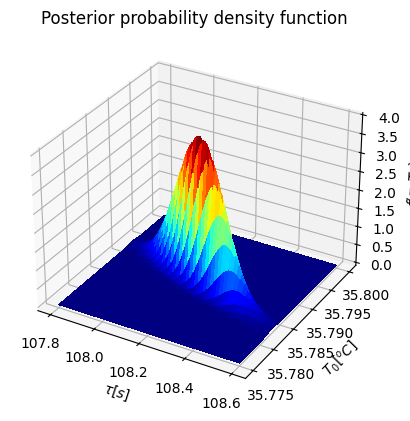

In [160]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(m_mesh, c_mesh, posterior_mesh, cmap=cm.jet,
                       linewidth=0, antialiased=False)

ax.set_xlabel('$\\tau [s]$')
ax.set_ylabel('$T_0 [^oC]$')
ax.set_zlabel('$f(\\tau,T_0)$')
plt.title("Posterior probability density function")
plt.savefig("grafico_3D.png")

In [161]:
# Range delle variabili su cui fare inferenza

#it works with uy=0.1, ux=0
range_m = (m_values[0], m_values[-1])
range_c = (c_values[0], c_values[-1])

#range_m = (0,10)
#range_c = (0,10)

# Integrale di normalizzazione della posterior
normalization, integral_error_norm = integrate.nquad(posterior, 
                                                    [range_m, #m
                                                     range_c  #c
                                                    ],
                                                    args=(Temp,time,uy_new,Tf)
                                                    )
print (normalization, integral_error_norm)

# Posterior normalizzata (PDF)
def posterior_norm(M,C,Y,X,SigmaY,Tf):    
    return posterior(M,C,Y,X,SigmaY,Tf) / normalization

# L'argomento dell'integrale del valore atteso di c^k 
def arg_E_c_k(M,C,k,Y,X,SigmaY,Tf):
    return np.power(C,k) * posterior_norm(M,C,Y,X,SigmaY,Tf)

# L'argomento dell'integrale del valore atteso di m^k 
def arg_E_m_k(M,C,k,Y,X,SigmaY,Tf):
    return np.power(M,k) * posterior_norm(M,C,Y,X,SigmaY,Tf)

# L'argomento dell'integrale del valore atteso di m*c
def arg_E_mc(M,C,Y,X,SigmaY,Tf):
    return M * C * posterior_norm(M,C,Y,X,SigmaY,Tf)

3.0758643129097746e-259 3.2564723742053905e-257


In [162]:
E_c, error_int_E_c = integrate.nquad(arg_E_c_k, 
                                    [range_m, #m
                                    range_c  #c
                                    ],
                                    args=(1,Temp, time, uy_new, Tf)#k=1
                                    )
E_c2, error_int_E_c2 = integrate.nquad(arg_E_c_k, 
                                        [range_m, #m
                                        range_c  #c
                                        ],
                                        args=(2,Temp, time, uy_new, Tf)#k=2
                                        )
Var_c = E_c2 - E_c**2
Sigma_c = math.sqrt(Var_c)

In [163]:
E_m, error_int_E_m = integrate.nquad(arg_E_m_k, 
                                    [range_m, #m
                                    range_c  #c
                                    ],
                                    args=(1,Temp, time, uy_new, Tf)#k=1
                                    )
E_m2, error_int_E_m2 = integrate.nquad(arg_E_m_k, 
                                        [range_m, #m
                                        range_c  #c
                                        ],
                                        args=(2,Temp, time, uy_new, Tf)#k=2
                                        )
Var_m = E_m2 - E_m**2
Sigma_m = math.sqrt(Var_m)

In [164]:
E_mc, error_int_E_mc = integrate.nquad(arg_E_mc, 
                                       [range_m, #m
                                        range_c  #c
                                        ],
                                        args=(Temp, time, uy_new, Tf)
                                        )
Cov_mc = E_mc - E_m*E_c
Rho_mc = Cov_mc / (Sigma_m*Sigma_c)

In [ ]:
with open("../info_post_aria.txt", "a") as f:
	f.write("\n\n*******************************************************")
	f.write(f"\n\nm_fit = {E_m:.20f} \pm {Sigma_m:.20f} [y/x] [{Sigma_m/E_m*100:.2f}%]\n")
	f.write(f"c_fit = {E_c:.20f} \pm {Sigma_c:.20f} [y] [{Sigma_c/E_c*100:.2f}%]\n")
	f.write(f"Cov[m,c] fit {Cov_mc}\n")
	f.write(f"Rho[m,c] fit {Rho_mc}\n")


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h7/5fmdn1ys2_g27vgk683vmkc80000gn/T/ipykernel_49733/901204251.py:3: SyntaxWarning: invalid escape sequence '\p'
  f.write(f"\n\nm_fit{E_m:.20f} \pm {Sigma_m:.20f} [y/x] [{Sigma_m/E_m:.2f}%]\n")
/var/folders/h7/5fmdn1ys2_g27vgk683vmkc80000gn/T/ipykernel_49733/901204251.py:4: SyntaxWarning: invalid escape sequence '\p'
  f.write(f"c_fit{E_c:.20f} \pm {Sigma_c:.20f} [y] [{Sigma_c/E_c:.2f}%]\n")


# Distribuzione marginale di c

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h7/5fmdn1ys2_g27vgk683vmkc80000gn/T/ipykernel_49733/1466497500.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(x = E_c+Sigma_c, color = 'orange', linestyle='--', label='$E[c] \pm 1\sigma$')


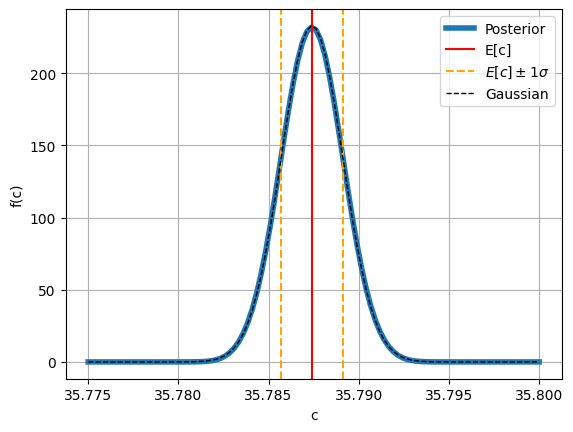

In [166]:
def posterior_1(M, C, T, t, sigmaT, Tf):
    Yexp = Tf - (Tf - C)*np.exp(-t/M)
    return np.prod(stats.norm.pdf(T, Yexp, sigmaT))

def posterior_1_norm(M,C,T,t,SigmaT, Tf):    
    return posterior_1(M,C,T,t,SigmaT, Tf) / normalization

posterior_norm_c = lambda C: integrate.nquad(posterior_1_norm, [range_m], args=(C,Temp,time,uy_new, Tf))[0]
posterior_norm_c_vfunc = np.vectorize(posterior_norm_c)

posterior_norm_c_values = posterior_norm_c_vfunc(c_values)

plt.plot(c_values,posterior_norm_c_values,label='Posterior',linewidth=4)
plt.xlabel("c")
plt.ylabel("f(c)")
plt.axvline(x = E_c, color = 'r', linestyle='-',label='E[c]')
plt.axvline(x = E_c+Sigma_c, color = 'orange', linestyle='--', label='$E[c] \pm 1\sigma$')
plt.axvline(x = E_c-Sigma_c, color = 'orange', linestyle='--')
plt.plot(c_values, stats.norm.pdf(c_values,E_c,Sigma_c), linewidth=1, color='black',linestyle='--',label='Gaussian')
plt.legend()
plt.grid()

# Distribuzione marginale di m

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h7/5fmdn1ys2_g27vgk683vmkc80000gn/T/ipykernel_49733/4060162081.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(x = E_m+Sigma_m, color = 'orange', linestyle='--', label='$E[m] \pm 1\sigma$')


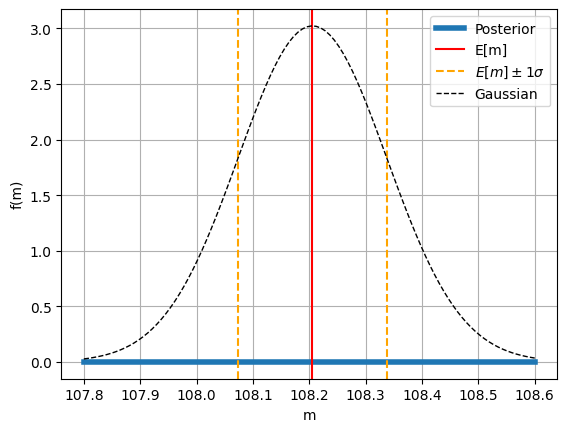

In [167]:
def posterior_2(C, M, T, t, sigmaT, Tf):
    Yexp = Tf - (Tf - C)*np.exp(-t/M)
    return np.prod(stats.norm.pdf(T, Yexp, sigmaT))

def posterior_2_norm(C, M, T, t, sigmaT, Tf):    
    return posterior_2(M, C, T, t, sigmaT, Tf) / normalization

posterior_norm_m = lambda M: integrate.nquad(posterior_2_norm, [range_c], args=(M, Temp, time, uy_new, Tf))[0]
posterior_norm_m_vfunc = np.vectorize(posterior_norm_m)

posterior_norm_m_values = posterior_norm_m_vfunc(m_values)

plt.plot(m_values,posterior_norm_m_values,label='Posterior',linewidth=4)
plt.xlabel("m")
plt.ylabel("f(m)")
plt.axvline(x = E_m, color = 'r', linestyle='-',label='E[m]')
plt.axvline(x = E_m+Sigma_m, color = 'orange', linestyle='--', label='$E[m] \pm 1\sigma$')
plt.axvline(x = E_m-Sigma_m, color = 'orange', linestyle='--')
plt.plot(m_values, stats.norm.pdf(m_values,E_m,Sigma_m), linewidth=1, color='black',linestyle='--',label='Gaussian')
plt.legend()
plt.grid()

